# QQA

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import gc

from src import utils
from src import qqa
from src import instance

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
SEED = 0
utils.fix_seed(SEED)
torch_type = torch.float32

## Maximum Independent Set

### Step 1: Define Problem Class

In [8]:
# Graph Parameters
N, d, p = 50, 3, None
nx_graph = nx.random_regular_graph(d=d, n=N, seed=SEED)
# problem = instance.MaximumIndependentSet(nx_graph, penalty=2, device=device)

# Custom Problem Classの作り方.
class MaximumIndependentSet(instance.COProblem):
    def __init__(self, nx_graph, penalty=3, device="cpu"):
        super().__init__()
        self.nx_graph = nx_graph
        self.penalty = penalty
        self.device = device
        self.num_nodes = nx_graph.number_of_nodes()
        self.Q_mat = self.generate_qubo_matrix()

    def generate_qubo_matrix(self):
        Q = torch.full((self.num_nodes, self.num_nodes), 0.0)
        for (u, v) in self.nx_graph.edges:
            Q[u][v] = self.penalty
            Q[v][u] = self.penalty
        for u in self.nx_graph.nodes:
            Q[u][u] = -1
        return Q.to(self.device)

    def loss_fn(self, x):
        return torch.einsum('bi,ij,bj->b', x, self.Q_mat, x)

problem = MaximumIndependentSet(nx_graph, penalty=2, device=device)

### Step 2: Run QQA


============================== [LOG] ===============================
[ EPOCH 0 ]
  Best Loss So Far : 3.0000
  Mean(Loss)       : 57.0996
  Mean(Penalty)    : 40.0717
  BG               : -3.0000
  DIV Value        : 14.3374
  div_param        : 0.2000

============================== [LOG] ===============================
[ EPOCH 500 ]
  Best Loss So Far : -4.0000
  Mean(Loss)       : 24.0088
  Mean(Penalty)    : 0.0212
  BG               : -2.4833
  DIV Value        : 24.8279
  div_param        : 0.2000

============================== [LOG] ===============================
[ EPOCH 1000 ]
  Best Loss So Far : -4.0000
  Mean(Loss)       : 24.0400
  Mean(Penalty)    : 0.0000
  BG               : -1.9667
  DIV Value        : 24.8313
  div_param        : 0.2000

============================== [LOG] ===============================
[ EPOCH 1500 ]
  Best Loss So Far : -4.0000
  Mean(Loss)       : 24.0400
  Mean(Penalty)    : 0.0000
  BG               : -1.4500
  DIV Value        : 24.8313
  di

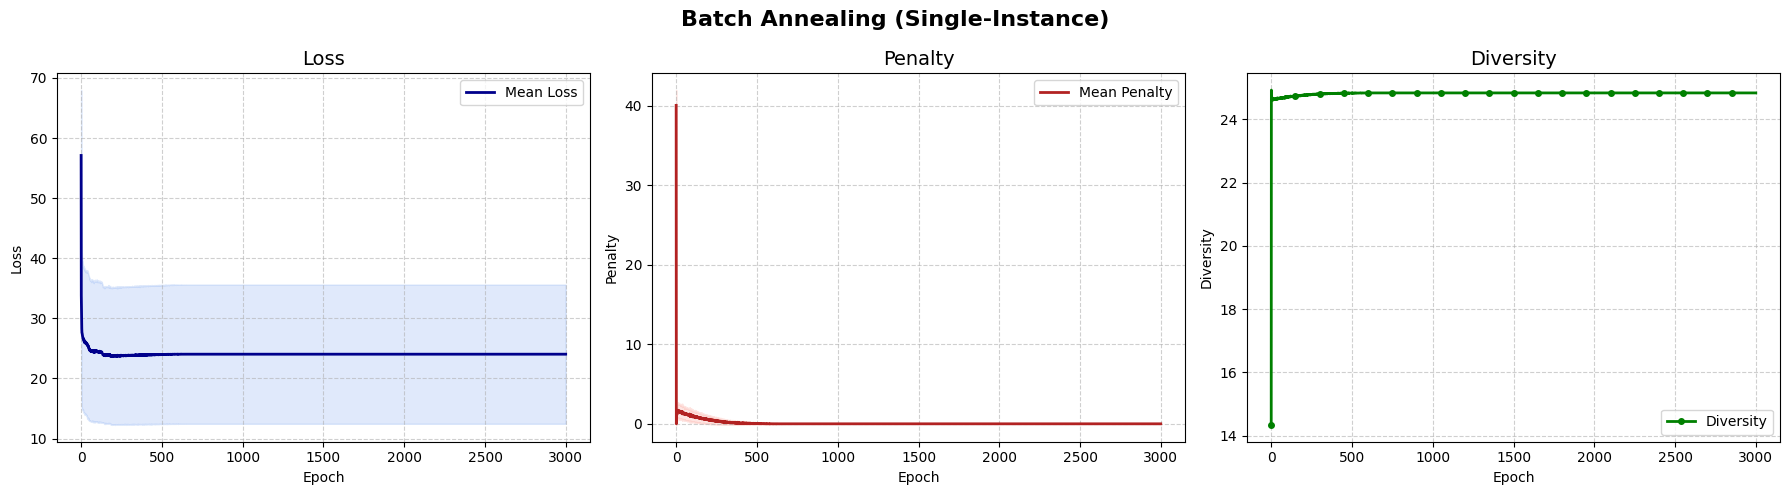

In [9]:
# QQA Parameters
cfg = {'sol_size':100,
        'learning_rate':1,
        'temp':0.001,
        'min_bg':-3,
        'max_bg':0.1,
        'curve_rate':4,
        'div_param':0.2}

best_sol, best_obj, runtime = qqa.batch_annealing(problem,
                                                sol_size=100,
                                                learning_rate=cfg['learning_rate'],
                                                temp=cfg['temp'],
                                                min_bg=cfg['min_bg'],
                                                max_bg=cfg['max_bg'],
                                                curve_rate=cfg['curve_rate'],
                                                div_param=cfg['div_param'],
                                                num_epochs=int(3e3),
                                                check_interval=500,
                                                device=device,
                                                plot_dynamics=True)

### Step 3: Visualization

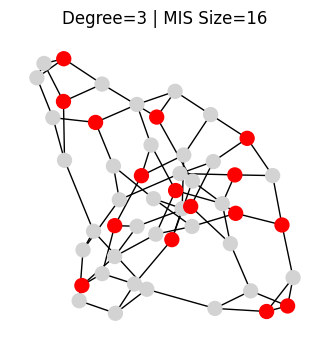

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))

best_sol_np = best_sol[problem.loss_fn(best_sol).argmin()].detach().cpu().numpy()
color_map = ['red' if best_sol_np[node] == 1 else 'lightgray' for node in nx_graph.nodes()]
pos = nx.spring_layout(nx_graph, seed=42)  # レイアウト

nx.draw(
    nx_graph,
    pos=pos,
    node_color=color_map,
    with_labels=False,
    ax=ax,
    node_size=100
)

ax.set_title(f"Degree={d} | MIS Size={int(best_sol_np.sum())}")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

## Coloring

### Step 1: Define Problem Class

In [11]:
num_nodes = 50
degree = 5
random_graph = nx.random_regular_graph(d=degree, n=num_nodes)
problem = instance.Coloring(random_graph, 
                            num_category=4, 
                            device=device)

### Step 2: Run QQA


============================== [LOG] ===============================
[ EPOCH 0 ]
  Current Best Obj  : 18.0000
  Mean(Loss)        : 31.2984
  Mean(Penalty)     : 49.2797
  BG                : -3.0000
  DIV Value         : -697.8334
  div_param         : 0.2000

============================== [LOG] ===============================
[ EPOCH 500 ]
  Current Best Obj  : 0.0000
  Mean(Loss)        : 14.1353
  Mean(Penalty)     : 47.7854
  BG                : -2.4833
  DIV Value         : -1194.6387
  div_param         : 0.2000

============================== [LOG] ===============================
[ EPOCH 1000 ]
  Current Best Obj  : 0.0000
  Mean(Loss)        : 13.5361
  Mean(Penalty)     : 47.5220
  BG                : -1.9667
  DIV Value         : -1220.0564
  div_param         : 0.2000

============================== [LOG] ===============================
[ EPOCH 1500 ]
  Current Best Obj  : 0.0000
  Mean(Loss)        : 13.1944
  Mean(Penalty)     : 47.2866
  BG                : -1.4500
  

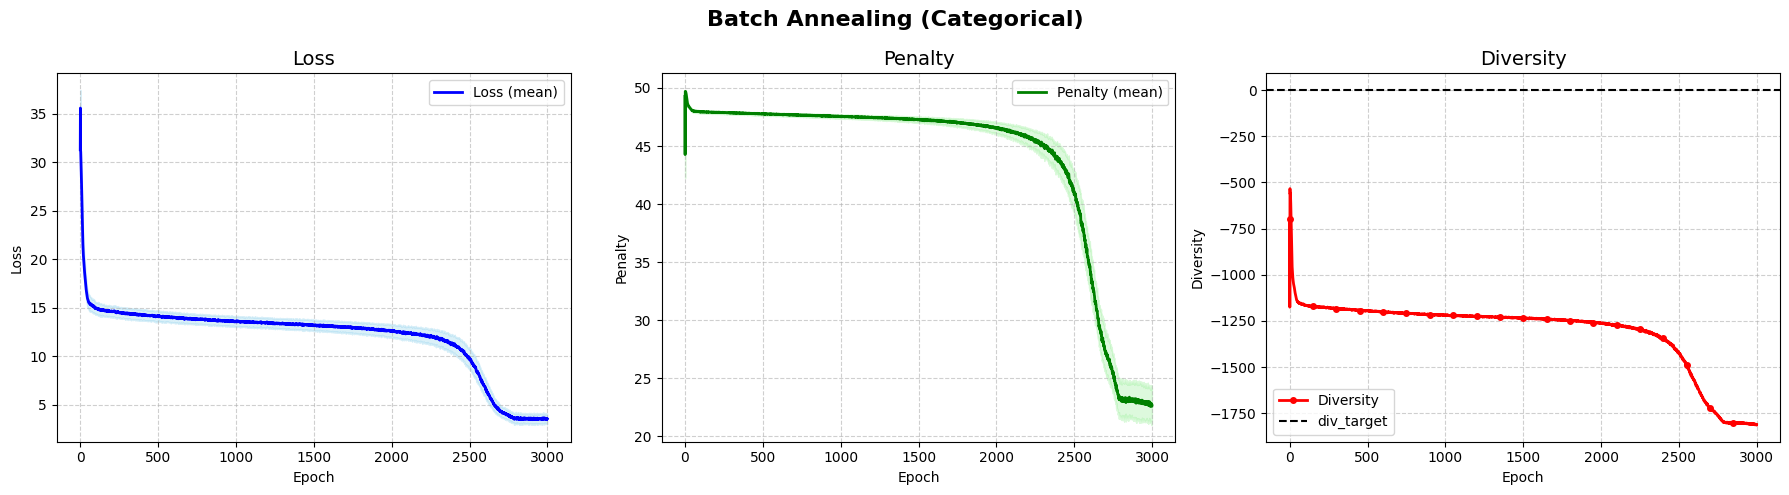

In [12]:
cfg = {
        'sol_size':100,
        'learning_rate':1,
        'temp':0.001,
        'min_bg':-3,
        'max_bg':0.1,
        'curve_rate':4,
        'div_param':0.2
        }

best_sol, best_obj, runtime = qqa.batch_annealing_categorical(problem,
                                    sol_size=100,
                                    learning_rate=cfg['learning_rate'],
                                    temp=cfg['temp'],
                                    min_bg=cfg['min_bg'],
                                    max_bg=cfg['max_bg'],
                                    curve_rate=cfg['curve_rate'],
                                    div_param=cfg['div_param'],
                                    num_epochs=int(3e3),
                                    check_interval=500,
                                    device=device,
                                    plot_dynamics=True)

### Step 3: Visualization

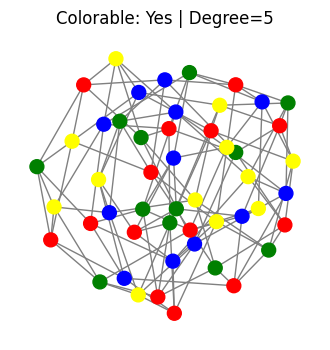

In [13]:

fig, ax = plt.subplots(figsize=(4, 4))
color_map = ["red", "blue", "green", "yellow", "purple", "orange", "pink", "cyan", "lime", "brown"]
node_colors = [color_map[color] for color in best_sol]
pos = nx.spring_layout(random_graph, seed=100)
nx.draw(
    random_graph, pos=pos, node_color=node_colors, with_labels=False, edge_color="gray",
    node_size=100, linewidths=1, ax=ax
)
ax.set_title(f"Colorable: {'Yes' if int(best_obj)==0 else 'No'} | Degree={degree}")
ax.set_xticks([])
ax.set_yticks([])
plt.show()


## Optional: Parallel Solving for Different Instances

### Step 1: Define Problem Class

In [14]:
num_nodes = 100
degree_list = [2, 3, 4, 5]
nx_graph_list = [nx.random_regular_graph(d=degree, n=num_nodes) for degree in degree_list]
problem = instance.MaximumIndependentSetInstance(nx_graph_list, max_node=num_nodes, penalty=2, device=device)

### Step 2: Run QQA


============================== [LOG] ===============================
[ EPOCH 0 ]
  Current Best Obj : [ -8. -10. -12.  -6.]
  Mean(Loss)       : 140.7571
  Mean(Penalty)    : 79.7006
  BG               : -3.0000
  div_param        : 0.2000

============================== [LOG] ===============================
[ EPOCH 99 ]
  Current Best Obj : [-48. -43. -40. -35.]
  Mean(Loss)       : -38.5701
  Mean(Penalty)    : 0.9948
  BG               : 0.0690
  div_param        : 0.2000

============================== [FINAL] ==============================
  BEST LOSS:[-48. -43. -40. -35.]
  RUN TIME:1.43 s
sol_size:100, learning_rate:1, temp:0.001, min_bg:-3, max_bg:0.1, curve_rate:4, div_param:0.2


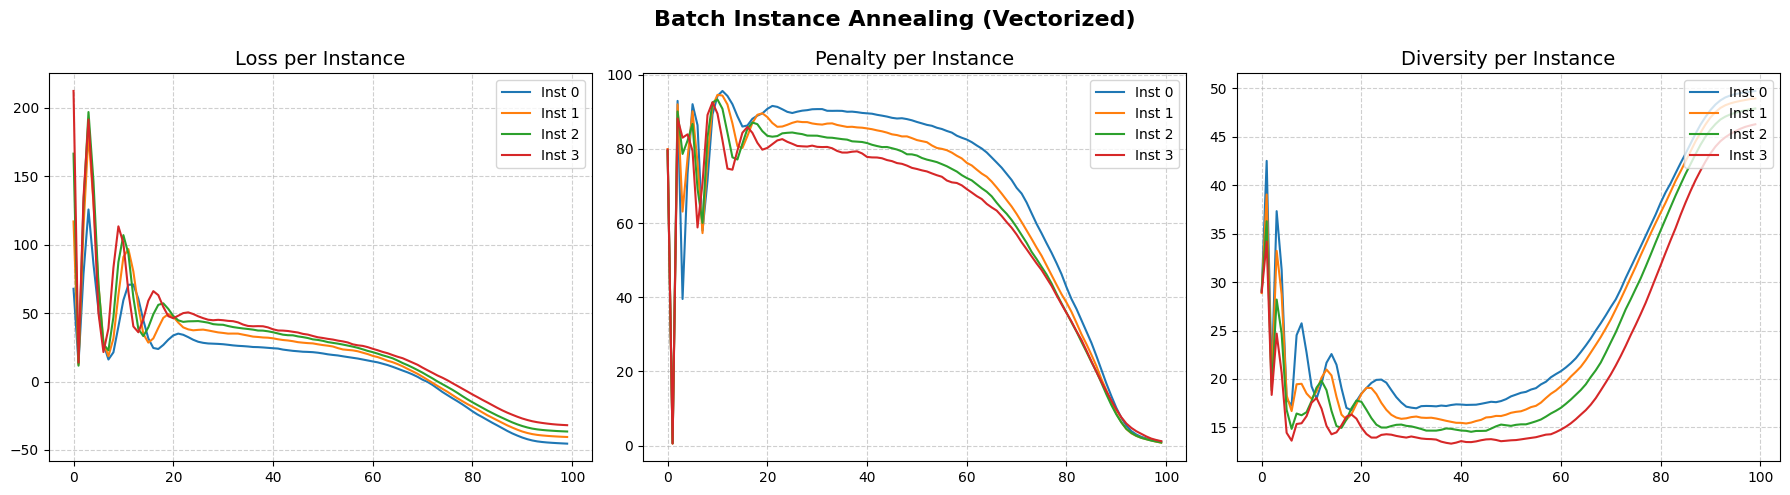

In [15]:
cfg = {'sol_size':100,
                'learning_rate':1,
                'temp':0.001,
                'min_bg':-3,
                'max_bg':0.1,
                'curve_rate':4,
                'div_param':0.2}
num_nodes = 100
degree_list = [2, 3, 4, 5]
nx_graph_list = [nx.random_regular_graph(d=degree, n=num_nodes) for degree in degree_list]


problem = instance.MaximumIndependentSetInstance(nx_graph_list, max_node=num_nodes, penalty=2, device=device)


best_sol, best_obj, runtime = qqa.batch_instance_annealing(problem,
                                                    sol_size=cfg['sol_size'],
                                                    learning_rate=cfg['learning_rate'],
                                                    temp=cfg['temp'],
                                                    min_bg=cfg['min_bg'],
                                                    max_bg=cfg['max_bg'],
                                                    curve_rate=cfg['curve_rate'],
                                                    div_param=cfg['div_param'],
                                                    num_epochs=int(1e2),
                                                    check_interval=1000,
                                                    device=device,
                                                    plot_dynamics=True)

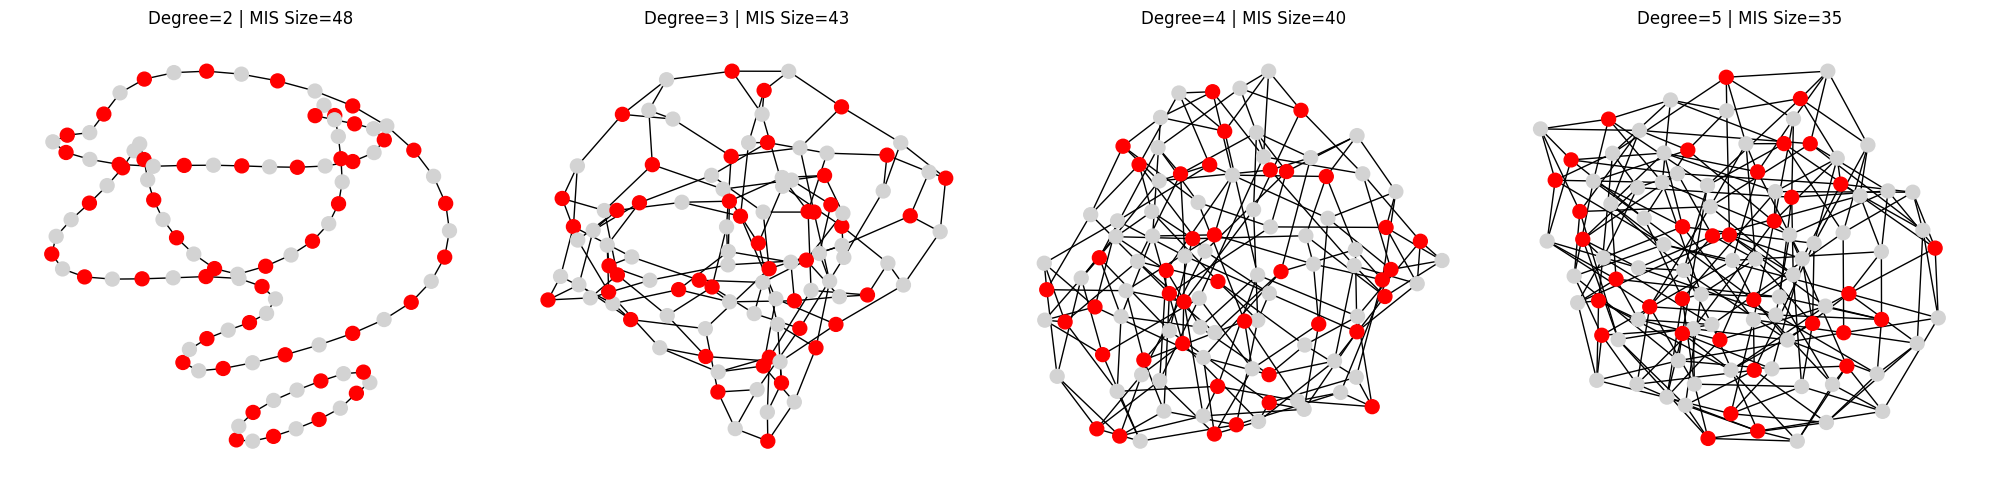

In [16]:
# グラフを横並びにプロット
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, (graph, ax) in enumerate(zip(nx_graph_list, axes)):
    best_sol_np = best_sol[i].detach().cpu().numpy()
    color_map = ['red' if best_sol_np[node] == 1 else 'lightgray' for node in graph.nodes()]
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(
        graph, pos=pos, node_color=color_map, with_labels=False, ax=ax, node_size=100,
    )
    ax.set_title(f"Degree={degree_list[i]} | MIS Size={int(best_sol[i].sum())}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()